In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt

from keras import Sequential, models, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import SGD, Adam

2022-10-18 12:42:41.942841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 12:42:42.132900: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 12:42:42.797838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-10-18 12:42:42.797922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfe

## Read csv

In [2]:
df = pd.read_csv("../../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df = df[["Filename", "Stage", "Discharge"]]

In [5]:
from sklearn.preprocessing import StandardScaler
from joblib import load

#scaler = StandardScaler()
scaler = load('../std_scaler.joblib')

In [6]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge
0,StateLineWeir_20120609_Farrell_001.jpg,0.138117,-0.046094
1,StateLineWeir_20120609_Farrell_002.jpg,0.138117,-0.046094
2,StateLineWeir_20120609_Farrell_003.jpg,0.100875,-0.082160
3,StateLineWeir_20120609_Farrell_004.jpg,0.076046,-0.104807
4,StateLineWeir_20120609_Farrell_005.jpg,0.076046,-0.104807
...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.420526,-0.450369
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.420526,-0.450369
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.420526,-0.450369
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.420526,-0.450369


## Create dataset

In [7]:
IMG_SIZE = 512
BATCH_SIZE = 32

In [8]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    image = tf.cast(image, tf.float32) / 255
    return image

  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    return ds

  filenames = glob(path + '/*')

  # create stage values
  stage_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in filenames]

  # create discharge values
  discharge_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in filenames]

  # join stage and discharge values
  stage_discharge_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_values, discharge_values)]

  # create images dataset (train, val, test)
  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)

  images_ds = filenames_ds.map(parse_image, num_parallel_calls=8)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_values)

  # create tensorflow dataset of images and values (train, val, test)
  ds = tf.data.Dataset.zip((images_ds, stage_discharge_ds))
  ds = configure_for_performance(ds)

  return ds

In [15]:
path = "../../../dataset/images_testing"

test_ds = make_dataset(path, BATCH_SIZE, df, 10)

## Show images

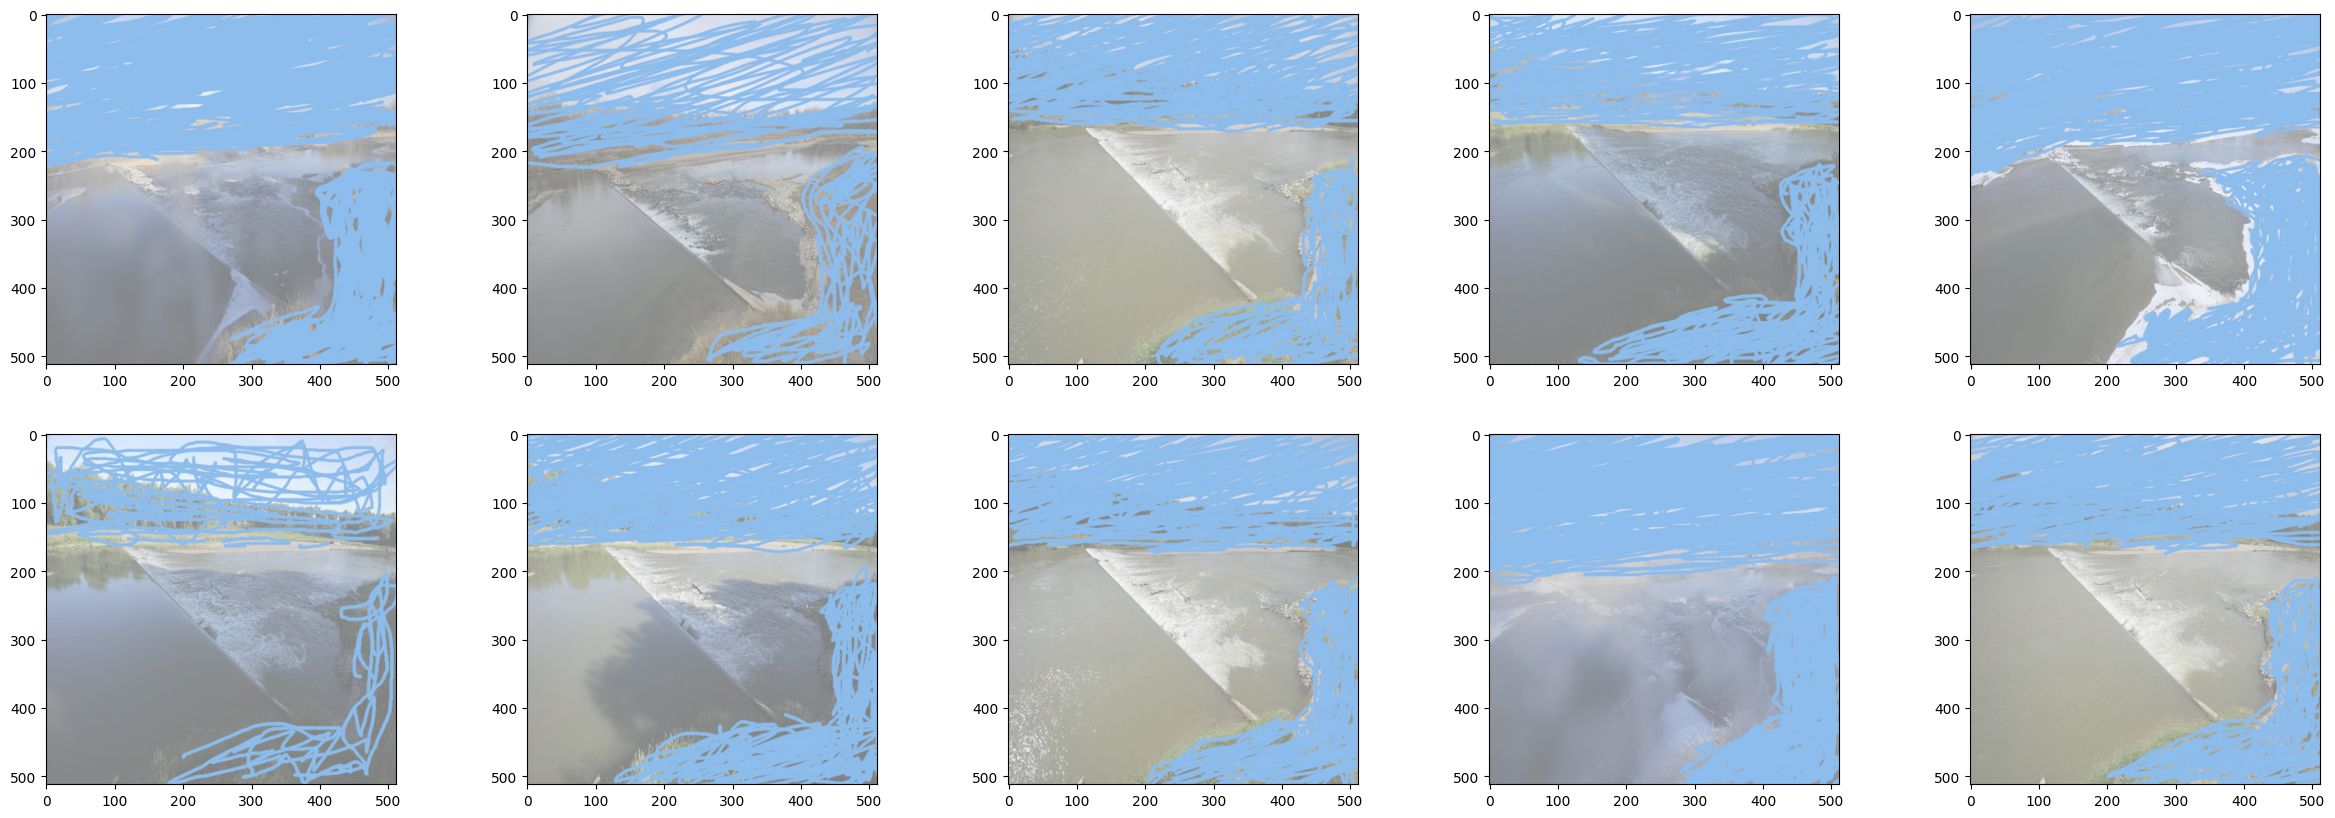

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Test model

In [17]:
best_model = models.load_model(f'model_weights/cnn_best_weights_v10.hdf5')

In [18]:
def evaluate_model(model, test_values):
  score = model.evaluate(test_values)
  return score

In [19]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds)

1/1 [==============================] - 0s 162ms/step - loss: 0.0049 - mse: 0.0049 - rmse: 0.0698 - mae: 0.0437 - mape: 20.7169


2% a 4% peor de error, con esto podemos decir qye nuestro modelo en realidad se llega a concentrar en el agua y no en el escenario, podemos decir que nuestro modelo se concentra en el rio para sacar la informacion sobre el problema y que en realidad esta encontrando algo que probablemente si tiene causalidad con el problema en el agua.